# Infering the Mass-Luminosity Relation with Physical Components

*David Thomas 2017/01/10*

## Background

Modern numerical simulations have given us a good understanding of dark matter structure for standard cosmological scenarios, while surveys have done the same for the distribution of galaxies. This has allowed us to develop a good picture of how mass and luminosity are distributed in the universe. However, there is still work to be done connecting these two distributions. [1]

We are proposing to infer the relationship between dark matter halo mass and galaxy luminosity (mass-luminosity) from a strategically chosen field of view in the Millennium Simulation dataset. The field of view will be chosen such that it contains a high mass dark matter halo which we will use to callibrate our inference. The deliverable will be a 2D contour plot of galaxy luminosity vs dark matter halo mass. Special attention will be given to the luminosity scatter at the low-mass end of the spectrum, $10^{11}-10^{12}$ solar masses, which is less constrained. The resulting contour plot will help researchers further measure and constrain the mass-luminosity relation.

##### Catalog

We will use a halo catalog from the Millennium Simulation, a 10 billion particle simulation with high resolution, as the test bed for our inference. The particles in the simulation have a mass of $8.6 \times 10^{8}$/h solar masses which gives the data a resolution which will allow us to better study the mass-luminosity dark in the low mass region. [2] 

##### Dark Matter Halo Profiles

It is typical to represent dark matter structure in a space by a collection of spherically symmetric density profiles. The canonical profile for Cold Dark Matter structure is the NFW profile [3]: 
 
$$\rho_{NFW}(r) = \frac{\rho_0}{\frac{r}{R_s}\Big(1 + \frac{r}{R_s}\Big)^2}$$

where the scale radius $R_s$ and density $\rho_0$ are halo dependent. However, the total mass of this profile diverges when integrated out to infinity. To resolve this issue, we use the BMO profile [4]:  

$$\rho_{BMO}(r) = \rho_{NFW}(r) \cdot\Big(\frac{r_t^2}{r^2+r_t^2}\Big)^2$$

where $r_t$ is the truncation radius that has been shown to be a better fit to simulated data. This choice also has computational benefits for our weak lensing model.

##### Weak Lensing Model 

(borrowed with little modification from [6])
We infer the BMO profiles by comparing the ellipticity e of N synthetic background galaxies to the ray traced reduced shears g from [7]. The synthetic ellipicities are drawn independently from a Gaussian distribution with mean $g_j$. The likelihood function is

$$P(d|x) = \frac{1}{Z_L} exp\Big( - \frac{\chi^2}{2}\Big)$$

where d is the vector of ellipticity (component) values, and x are the parameters governing the halos used to compute the shear fields at the background galaxy positions. The $\chi^2$ and normalization factor are

$$\chi^2 = \sum^N_{i=1}\sum^2_{i=1} \frac{(\epsilon_{j,i} - g_{j,i}(x))^2}{\sigma^2}$$
$$Z_L = (2 \pi \sigma^2)^{2N/2}$$

We generate the observed ellipticity with intrinsic and observational dispersion contributions that are Gaussian and add in quadrature.

$$\sigma_{\epsilon} = \sqrt{\sigma_{int}^2 + \sigma_{obs}^2}$$

##### Lensing Code

Please see [8] to learn more about how our code computes the lensed ellipticities of background galaxies. 

#####  Cosmological Parameters

We use the same cosmological parameters in our model that are used in the Millennium Simulation to maintain consistency: $\Omega_M = 0.25, \Omega_\Lambda = 0.75, h = 0.73$.

##### Field of View

The field of view is a 1600 arcmin$^2$ field, a wide enough field to use weak lensing effects to infer halo masses. The field will be centered at (right ascension = -0.021112 rad, declination = -0.024584 rad) in the 'GGL_los_8_0_0_0_0_N_4096_ang_4_Guo_galaxies_on_plane_27_to_63.images.txt' file which corresponds to the most massive halo ($2.1 \times 10^{14}$ solar masses).

## Inference

##### Luminosity Function

The Schechter Function [5] is typically used to characterize galaxy luminosity functions and has the form 

$$\phi(L) = \Big(\frac{\phi^*}{L^*}\Big)\Big(\frac{L}{L^*}\Big)^\alpha e^{-(L/L^*)}$$

where $\phi(L)$ measures the number of galaxies per unit luminosity per unit volume. Typically the parameters $L^*, \phi^*$, and $\alpha$ are taken from observations across a selected wavelength band.

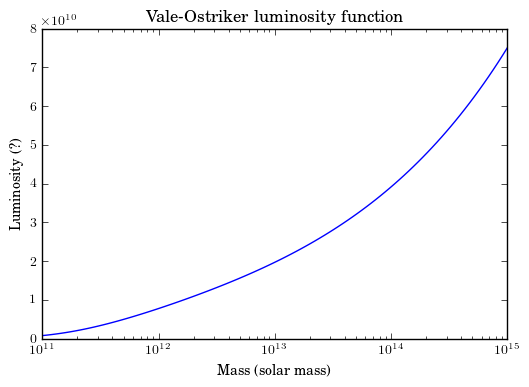

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

def L(m):
    A = 5.7e9
    mprime = 1e11
    b = 4
    c = 0.57
    d = 3.72
    k = 0.23
    numerator = A * ((m/mprime) ** b)
    denominator = (c + (m/mprime)**(d*k)) ** (1/k)
    return numerator / denominator

x = np.logspace(11, 15, 100, base=10.0)
y = map(L , x)
plt.semilogx(x,y)
plt.title('Vale-Ostriker luminosity function')
plt.xlabel('Mass (solar mass)')
plt.ylabel('Luminosity (?)')

##### Halo Mass Functions



##### Mass-Luminosity Relation

The mass-luminosity relation is calculated by setting the luminosity L of a galxy hosted in a halo of mass M to be connects mass and luminosity through the integrals

$$\int_L^\infty \phi(L) dL = \int^\infty_M [n_h(M) + n_{sh}(M)]dM$$

In [1] they found that the relation can be well fit by a double power law of the type:

$$L = A \frac{(m/m^\prime)^b}{(c + (m/m^\prime)^{dk})^{1/k}}$$

with the best fit parameters $A = 5.7 \times 10^9, m^\prime = 10^{11}, b = 4, c = 0.57, d = 3.72$, and $k=0.23$.

##### PGM 1 - Mock Luminosity Data Generation

This PGM shows how we will generate mock luminosities for each of the k halos in the field of view. 

- $\Omega$ represents cosmology hyperparameters.
- $M_h^k$ is the kth halo mass.
- $S$ is the scatter of the luminosity function.
- $\alpha$ is the luminosity function and its corresponding parameters.
- $L^k$ is the kth luminosity.
- $\sigma_L$ is the dispersion in the measurement of the luminosity.
- $L^k_{obs}$ is the kth observed luminosity.

$$P(L_i|M_{hi},S,\alpha) = \frac{1}{\sqrt{2\pi S^2 L_i^2}} \exp\Big(-\frac{(\log(L_i) - \log(\mu_{L_i}))^2}{2S^2}\Big) $$

where $\mu_L = f(M_{hi}, \alpha)$ is the Schechter function described above.

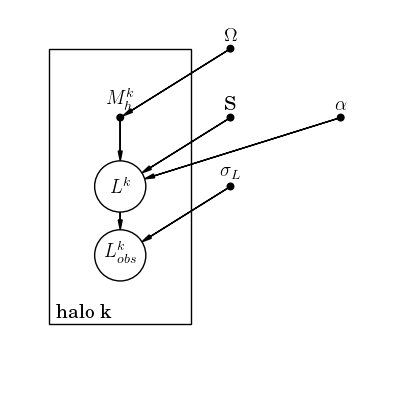

In [4]:
from matplotlib import rc
rc("font", family="serif", size=14)
rc("text", usetex=True)

import daft

pgm = daft.PGM([5, 5], origin=[0, 0])

#dimensions
plate_x = 0.5
plate_y = 1
plate_width = 1.8
plate_height = 3.5
plate_x_center = plate_x + (plate_width / 2.0)
plate_y_fourth = plate_height / 4.0
scale = 1.3

#plate
pgm.add_plate(daft.Plate([plate_x, plate_y, plate_width, plate_height], label="halo k"))

#nodes
pgm.add_node(daft.Node("m_h", "$M_h^k$", plate_x_center, plate_y + 3 * plate_y_fourth, fixed=True))
pgm.add_node(daft.Node("l", "$L^k$", plate_x_center, plate_y + 2 * plate_y_fourth, scale=scale))
pgm.add_node(daft.Node("l_obs", "$L^k_{obs}$", plate_x_center, plate_y + 1 * plate_y_fourth, scale=scale))

pgm.add_node(daft.Node("sigma_l", "$\sigma_L$", 2*plate_x_center, plate_y + 2 * plate_y_fourth, fixed=True))
pgm.add_node(daft.Node("s", "S", 2*plate_x_center, plate_y + 3 * plate_y_fourth, fixed=True))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 3*plate_x_center, plate_y + 3 * plate_y_fourth, fixed=True))
pgm.add_node(daft.Node("omega", r"$\Omega$", 2*plate_x_center, plate_y + 4 * plate_y_fourth, fixed=True))

#edges
pgm.add_edge("m_h", "l")
pgm.add_edge("l", "l_obs")
pgm.add_edge("sigma_l", "l_obs")
pgm.add_edge("s", "l")
pgm.add_edge("alpha", "l")
pgm.add_edge("omega", "m_h")

pgm.render()

##### PGM 2 - Learning Luminosity Hyperparameters
Below is the PGM that we will use to infer the luminosity scatter 'S' and the luminosity function '$\alpha$'. There are four differences in the inference PGM:
- $M_h^k, S, \alpha$ are now distributions.
- $L_{obs}^k$ is from data.
- the plate is over 'galaxies' as opposed to 'halos' to emphasize that we are generating the halos from assumptions in $\Omega$.

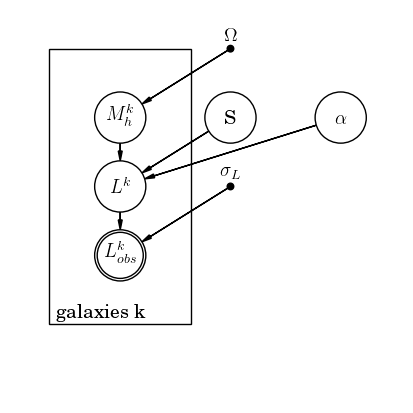

In [5]:
pgm = daft.PGM([5, 5], origin=[0, 0], observed_style="inner")

#dimensions
plate_x = 0.5
plate_y = 1
plate_width = 1.8
plate_height = 3.5
plate_x_center = plate_x + (plate_width / 2.0)
plate_y_fourth = plate_height / 4.0
scale = 1.3

#plate
pgm.add_plate(daft.Plate([plate_x, plate_y, plate_width, plate_height], label="galaxies k"))

#nodes
pgm.add_node(daft.Node("m_h", "$M_h^k$", plate_x_center, plate_y + 3 * plate_y_fourth, scale=scale))
pgm.add_node(daft.Node("l", "$L^k$", plate_x_center, plate_y + 2 * plate_y_fourth, scale=scale))
pgm.add_node(daft.Node("l_obs", "$L^k_{obs}$", plate_x_center, plate_y + 1 * plate_y_fourth, scale=scale, observed=True))

pgm.add_node(daft.Node("sigma_l", "$\sigma_L$", 2*plate_x_center, plate_y + 2 * plate_y_fourth, fixed=True))
pgm.add_node(daft.Node("s", "S", 2*plate_x_center, plate_y + 3 * plate_y_fourth, scale=scale))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 3*plate_x_center, plate_y + 3 * plate_y_fourth, scale=scale))
pgm.add_node(daft.Node("omega", r"$\Omega$", 2*plate_x_center, plate_y + 4 * plate_y_fourth, fixed=True))

#edges
pgm.add_edge("m_h", "l")
pgm.add_edge("l", "l_obs")
pgm.add_edge("sigma_l", "l_obs")
pgm.add_edge("s", "l")
pgm.add_edge("alpha", "l")
pgm.add_edge("omega", "m_h")

pgm.render()

#### Bias and Variance

#### Scipy Optimize Exploration

#### Performance Estimation

In [ ]:
1600 square arcminute
numerical optimization interface
    scipy optimize
have back of the envelope calculation of how long it will take to evaluate the likelihood
test scipy 1000 dimensional optimize log of gaussian

#### References
[1] A. Vale and J.P. Ostriker. Linking halo mass to galaxy luminosity. https://arxiv.org/pdf/astro-ph/0402500v2.pdf. 2004.

[2] V. Springel, S. D. M. White, A. Jenkins, C. S. Frenk, N. Yoshida, L. Gao, J. Navarro, R. Thacker, D. Croton, J. Helly, J. A. Peacock, S. Cole, P. Thomas, H. Couchman, A. Evrard, J. Colberg, and F. Pearce. Simulations of the formation, evolution and clustering of galaxies and quasars. http://www.nature.com/nature/journal/v435/n7042/full/nature03597.html. 2005.

[3] Julio F. Navarro, Carlos S. Frenk, Simon D.M. White. The Structure of Cold Dark Matter Halos. https://arxiv.org/pdf/astro-ph/9508025v1.pdf. 1995.

[4] Edward A. Baltz1, Phil Marshall1, Masamune Oguri1. Analytic models of plausible gravitational lens. https://arxiv.org/pdf/0705.0682v3.pdf. 2007.

[5] Paul Schechter. An Analytic Expression For The Luminosity Function of Galaxies. http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1976ApJ...203..297S&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf. 1975.

[6] Phil Marshall. Physical component analysis of galaxy cluster weak gravitational lensing data. https://arxiv.org/pdf/astro-ph/0511287v2.pdf. 2004.

[7] S. Hilbert, J. Hartlap, S.D.M. White1, and P. Schneider. Ray-tracing through the Millennium Simulation: Born corrections and lens-lens coupling in cosmic shear and galaxy-galaxy lensing. https://arxiv.org/pdf/0809.5035v2.pdf. 2009.

[8] Thomas E. Collett, Philip J. Marshall, Matthew W. Auger, Stefan Hilbert, Sherry H. Suyu, Zachary Greene, Tommaso Treu, Christopher D. Fassnacht, Leon V. E. Koopmans, Marusa Brada, Roger D. Blandford. Reconstructing the Lensing Mass in the Universe from Photometric Catalogue Data. https://arxiv.org/pdf/1303.6564v1.pdf. 2013.

#### Questions
- It seems like parent halo corresponds to cluster's central galaxy and then the other galaxies have subhalos [2], which is consistent with the Millennium Simulation data, can we discuss this a bit further?
- In $A = \frac{\gamma}{\beta\Gamma(2-\alpha)}$ (equation (1) from [1]) does $\Gamma$ represent the standard Gamma function from mathematics?
- Which halo mass function will we be using? Sheth Tormen?